# RNN for 3D keypoint generation

## Build network with Keras

In [1]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import time
import math
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
rc('animation', html='html5')
rcParams['animation.embed_limit'] = 2**128
import mdn

# Hacky. Is there a better way to load local modules?

#%run ../renderer/common.py

# still hacky but less hacky
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,os.path.join(parentdir, 'renderer')) 
from common import *

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


## Import keypoint sequences

In [3]:
data = []
basedir = '../data/train/'
for video_folder in os.listdir(basedir):
    for folder in os.listdir(basedir + video_folder):
        keypoints = np.load(basedir + video_folder + "/" + folder + "/" + 'pose3d.npz', allow_pickle=True)
        keypoints = keypoints['arr_0']
        data.append(keypoints)


In [4]:
np.shape(data[0])

(1296, 17, 3)

### Check data

**Note:** In order to render a video based on the pose3D data, please run `python renderer/render_pose3d_matplot.py ../data/train/seq_001/pose3d.npz --frames 300`

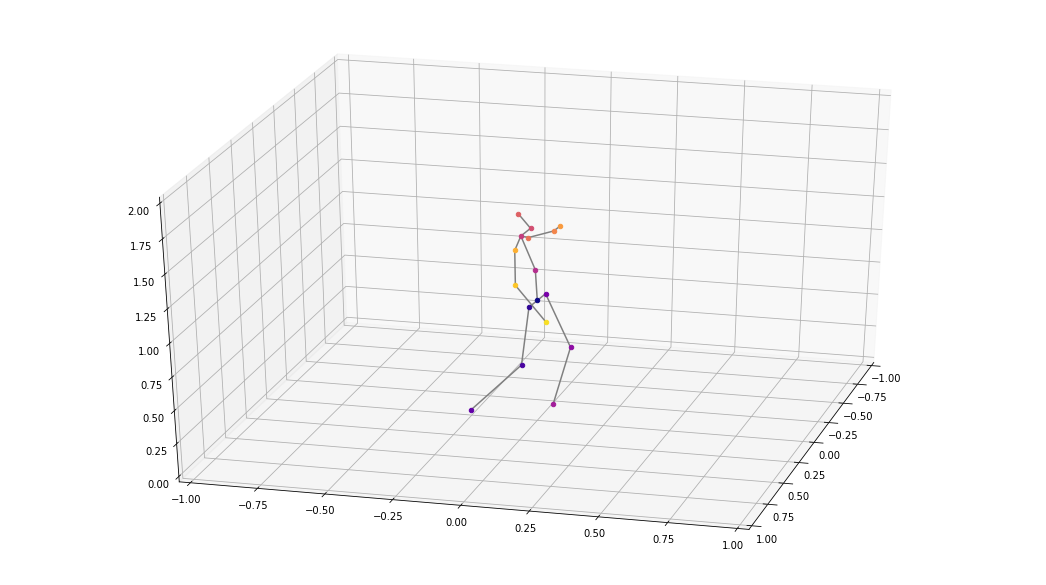

In [115]:
TEST_SEQ_ID = 23

fig, ax = init_plot()
# ax.view_init(30, -45)
plot_pose(ax, data[TEST_SEQ_ID][445])

In [ ]:
fig, ax = init_plot()
def animate(i):
    ax.clear()
    ax.view_init(30, -120)
    if i < len(data[TEST_SEQ_ID]):
        plot_pose(ax, data[TEST_SEQ_ID][i])

print(len(keypoints))
anim = FuncAnimation(fig, animate, frames=range(0,len(keypoints), 20), interval=200)
HTML(anim.to_html5_video())

In [7]:
def create_dataset(data, look_back = 1):
    dataX, dataY = [], []
    for dataset in data:
        # reshape input to be [samples, features = (keypoints*3dim)] 
        dataset = np.reshape(dataset,  (dataset.shape[0], dataset.shape[1]*dataset.shape[2]))
        for i in range(len(dataset) - look_back-1):
            # dataX has dimension [samples, lookback, features = (keypoints*3dim)] 
            a = dataset[i:(i + look_back), :]     
            dataX.append(a)
            # dataY has dimension [samples, features = (keypoints*3dim)] 
            dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)


look_back = 10
X, y = create_dataset(data,look_back)

In [8]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle= True, random_state=42)

# build model

In [19]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(look_back, 51),  return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(32))
model.add(mdn.MDN(51, 3))
model.compile(loss=mdn.get_mixture_loss_func(51,3), optimizer=keras.optimizers.Adam())
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 32)            10752     
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
mdn_1 (MDN)                  (None, 309)               10197     
Total params: 38,645
Trainable params: 38,645
Non-trainable params: 0
_________________________________________________________________


In [20]:
BATCH_SIZE = 128
limit = int(np.floor(len(X_train)/BATCH_SIZE))*BATCH_SIZE
EPOCHS = 1
VAL_SPLIT = 0.05

Train on 52183 samples, validate on 2747 samples
52096/52183 [============================>.] - ETA: 0s - loss: -45.1895
Epoch 00001: val_loss improved from inf to -74.36112, saving model to models/lstm_mdn-E01-VL-74.36.h5
52183/52183 [==============================] - 25s 482us/sample - loss: -45.2292 - val_loss: -74.3611


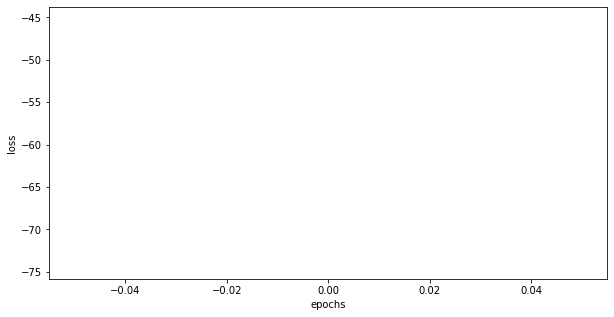

In [21]:
# Train the model

# Define callbacks
filepath="models/lstm_mdn-E{epoch:02d}-VL{val_loss:.2f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [keras.callbacks.TerminateOnNaN(), checkpoint, early_stopping]

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_split=VAL_SPLIT)

# Save the Model
model.save('models/lstm-mdn.h5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [17]:
# y_test = model.predict(X_test)
# y_samples = np.apply_along_axis(sample_from_output, 1, y_test, OUTPUT_DIMS, N_MIXES, temp=1.0)

In [12]:
%matplotlib inline
from IPython.display import HTML

def show_animation(dataset):
    fig, ax = init_plot()
    trainPredict_reshaped = np.reshape(dataset,(np.shape(dataset)[0],17,3))
    def animate(i):
        ax.clear()
        plot_pose(ax, trainPredict_reshaped[i])

    anim = FuncAnimation(fig, animate, frames=range(0,len(dataset),3), interval=200)
    plt.close()
    return HTML(anim.to_html5_video());

In [105]:
import matplotlib.cm as cm

def plot_pose(ax, frame):
    ax.clear()
#     ax.view_init(30, 135)
    ax.view_init(30, 15)
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(0, 2)

    for i,kp in enumerate(frame):
        ax.scatter(kp[0], kp[1], kp[2], color=cm.plasma(i/17))

    for (j_from, j_to) in bones:
        ax.plot3D(
            [frame[j_from][0], frame[j_to][0]],
            [frame[j_from][1], frame[j_to][1]],
            [frame[j_from][2], frame[j_to][2]],
            'gray')


In [14]:
def generate_performance(model, initial_positions, steps_limit=100, n_mixtures=3, temp=1.0, sigma_temp=0.0, look_back=10):
    """Generates aperformance"""
    time = 0
    steps = 0
    performance = [pose for pose in initial_positions]
    while (steps < steps_limit):
        params = model.predict(np.expand_dims(np.array(performance[-10:]), axis=0))
        new_pose = mdn.sample_from_output(params[0], 51, n_mixtures, temp=temp, sigma_temp=sigma_temp)
        performance.append(new_pose[0])
        steps += 1
    return np.array(performance)

In [22]:
seeds = range(0,len(X_test), int(len(X_test)/10))

test_performances = [generate_performance(model,X_test[seed], steps_limit=100) for seed in seeds]

In [17]:
longer_performance = generate_performance(model,X_test[1500], steps_limit=5000)

In [18]:
show_animation(longer_performance)

In [16]:
show_animation(test_performances[0])

In [33]:
# show_animation(test_performances[1])

In [23]:
show_animation(test_performances[2])

In [24]:
show_animation(test_performances[3])

In [ ]:
show_animation(test_performances[4])

In [ ]:
show_animation(test_performances[5])

In [ ]:
show_animation(test_performances[6])

In [ ]:
show_animation(test_performances[7])

In [ ]:
show_animation(test_performances[8])

In [ ]:
show_animation(test_performances[9])